# Модели ARIMA и GARCH

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.ar_model import ar_select_order
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of observations used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))
        
        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')
        
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

# Белый шум и случайные блуждания

Results of Dickey-Fuller Test:
Test Statistic                 -33.389421
p-value                          0.000000
#Lags Used                       0.000000
Number of observations used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


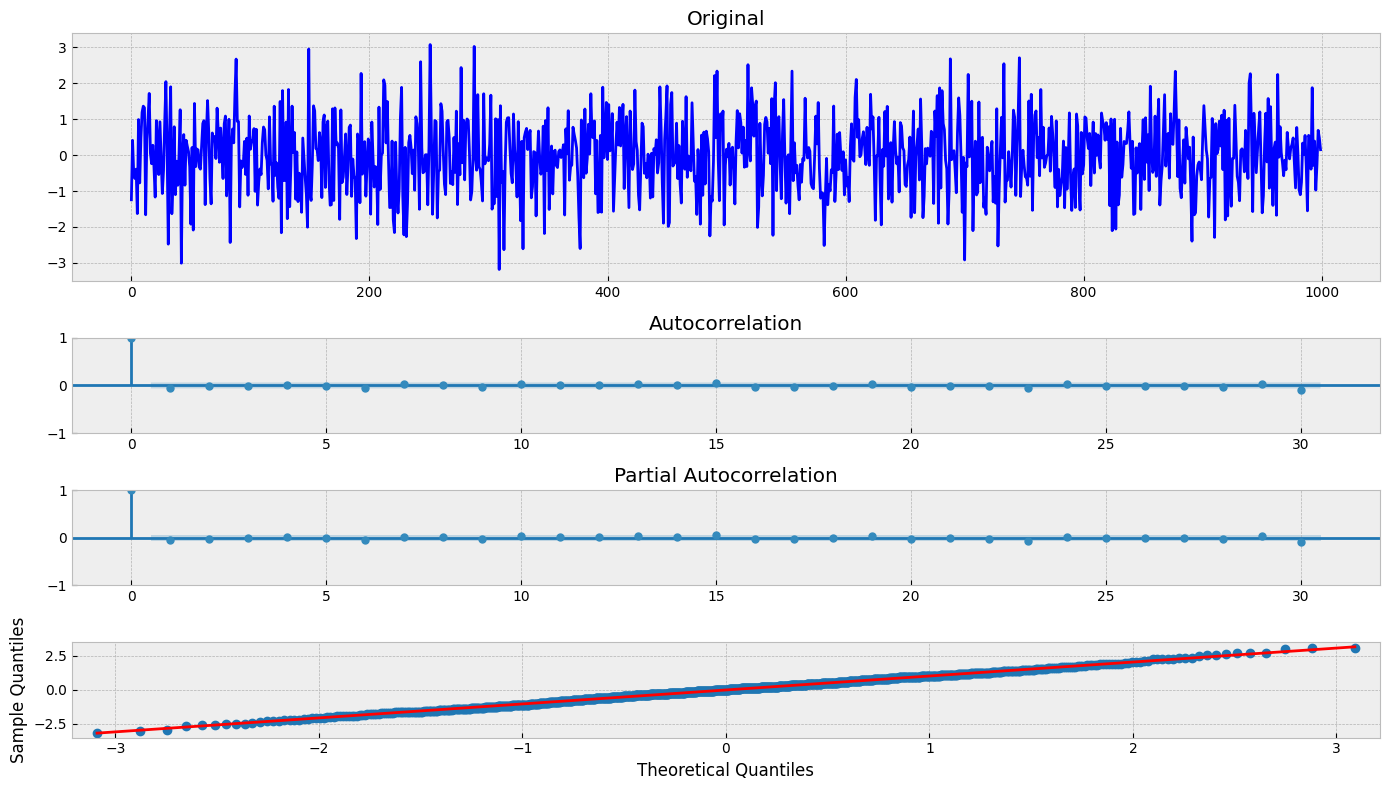

In [5]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

# Random Walk

Results of Dickey-Fuller Test:
Test Statistic                  -1.099859
p-value                          0.715128
#Lags Used                       3.000000
Number of observations used    996.000000
Critical Value (1%)             -3.436933
Critical Value (5%)             -2.864446
Critical Value (10%)            -2.568317
dtype: float64


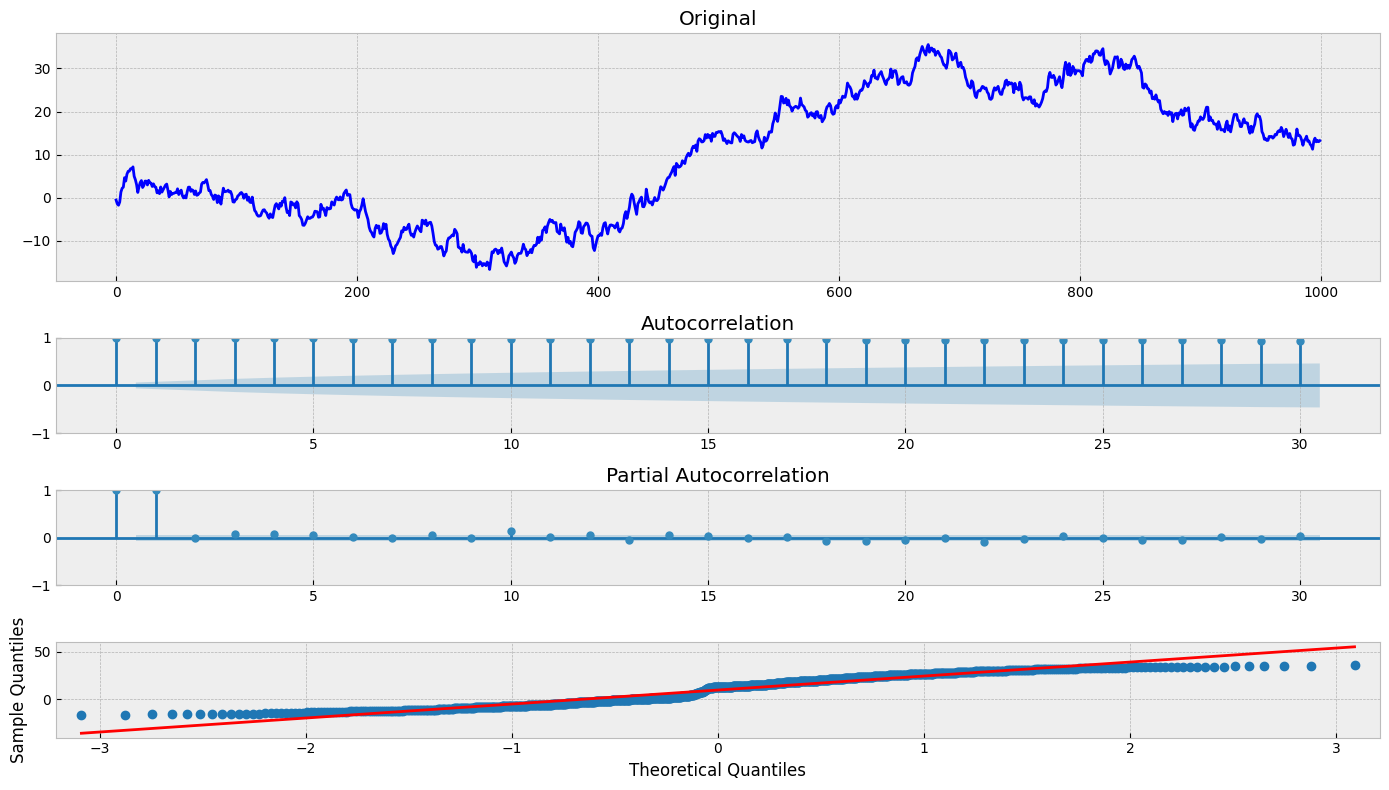

In [6]:
n_samples = 1000
x = np.random.normal(size=n_samples)
x = np.cumsum(x)
tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                 -19.880190
p-value                          0.000000
#Lags Used                       2.000000
Number of observations used    996.000000
Critical Value (1%)             -3.436933
Critical Value (5%)             -2.864446
Critical Value (10%)            -2.568317
dtype: float64


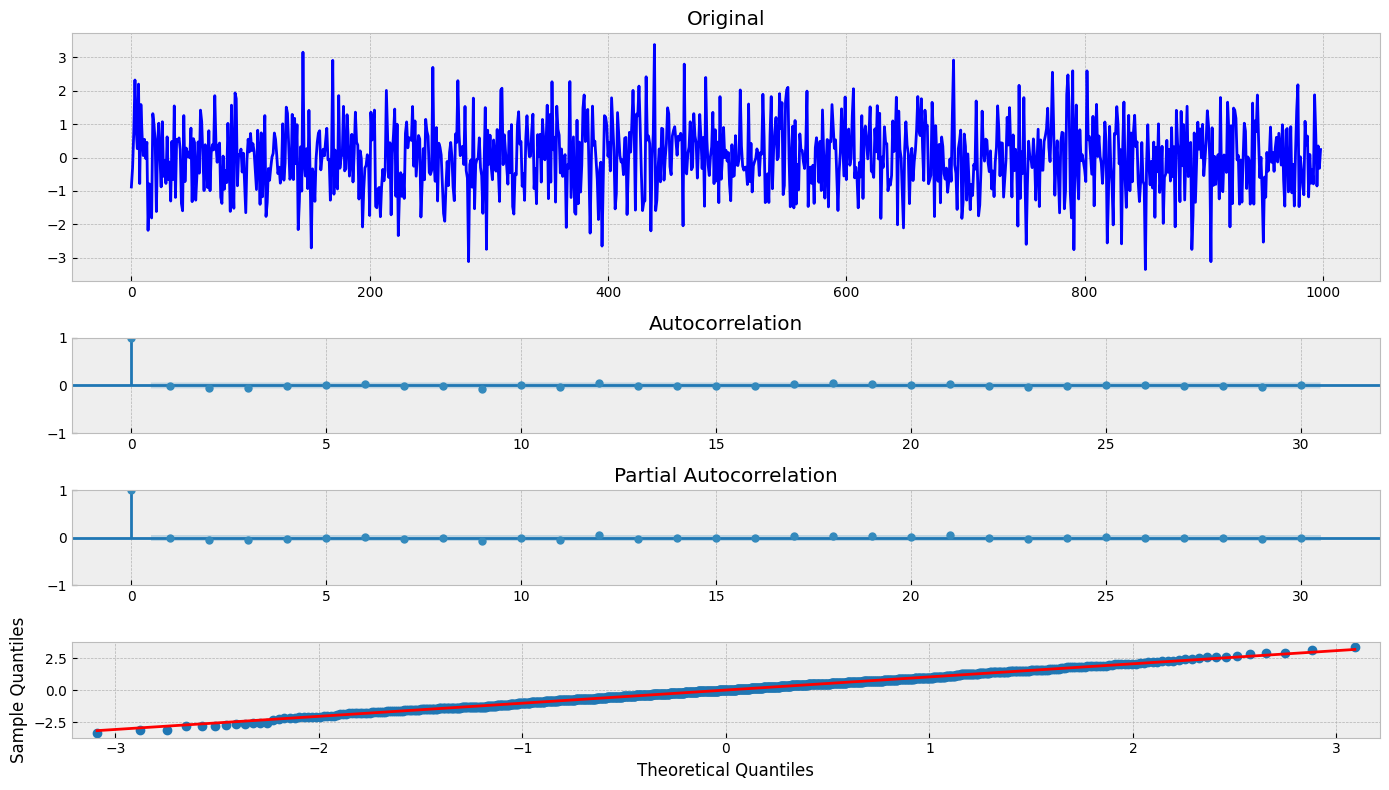

In [7]:
tsplot(np.diff(x), lags=30)

# AR(p)

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of observations used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


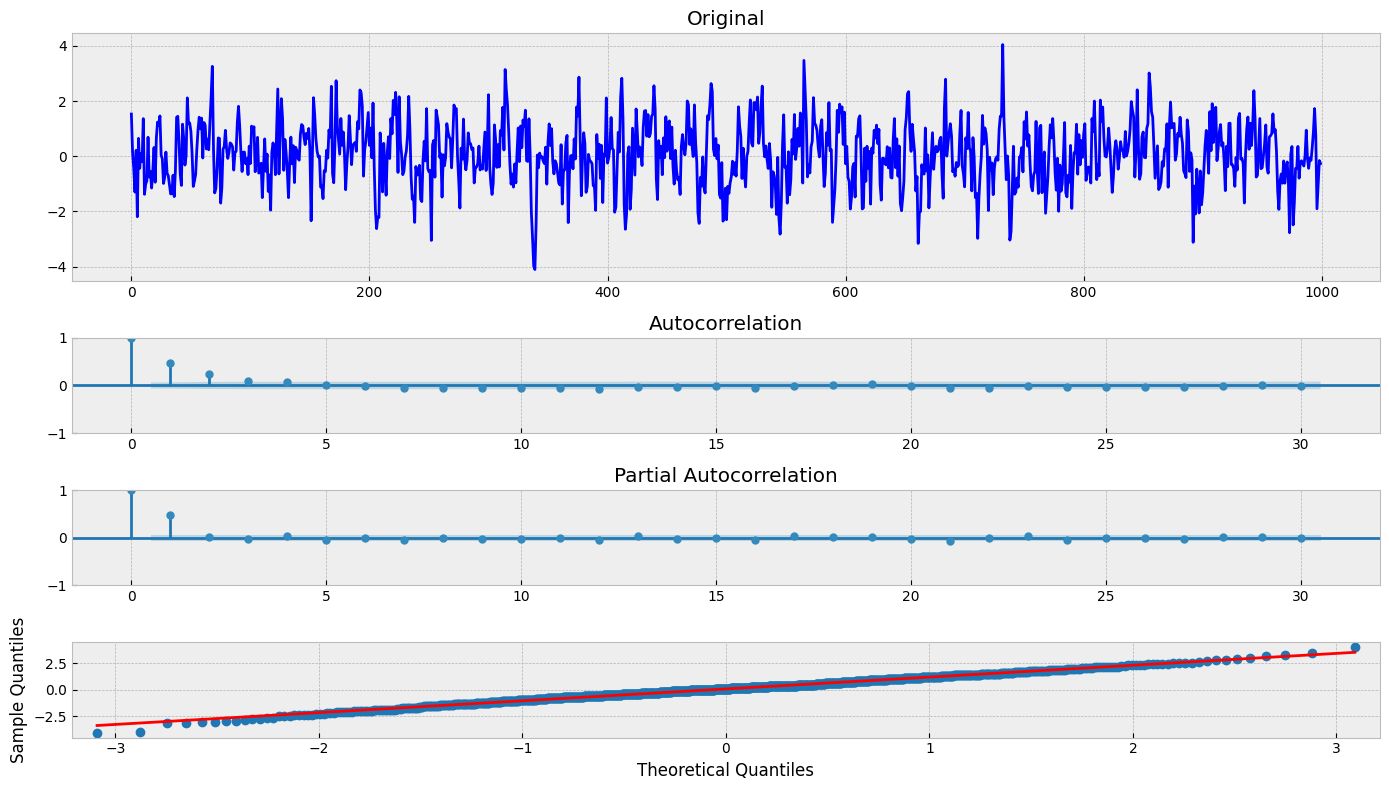

In [8]:
np.random.seed(1)
n_samples = int(1000)
a = .5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a * x[t - 1] + w[t]
    
tsplot(x, lags=30)

In [9]:
md1 = AR(x, lags=30, trend='c').fit()
est_order = ar_select_order(x, maxlag=30)

true_order = 1
print(f'\nalpha estimate: {md1.params[0]:3.5f} | best lag order = {est_order.ar_lags}')
print(f'\true alpha = {a} | true order = {true_order}')


alpha estimate: 0.05982 | best lag order = [1]
	rue alpha = 0.5 | true order = 1


Results of Dickey-Fuller Test:
Test Statistic                 -31.098024
p-value                          0.000000
#Lags Used                       0.000000
Number of observations used    969.000000
Critical Value (1%)             -3.437116
Critical Value (5%)             -2.864527
Critical Value (10%)            -2.568361
dtype: float64


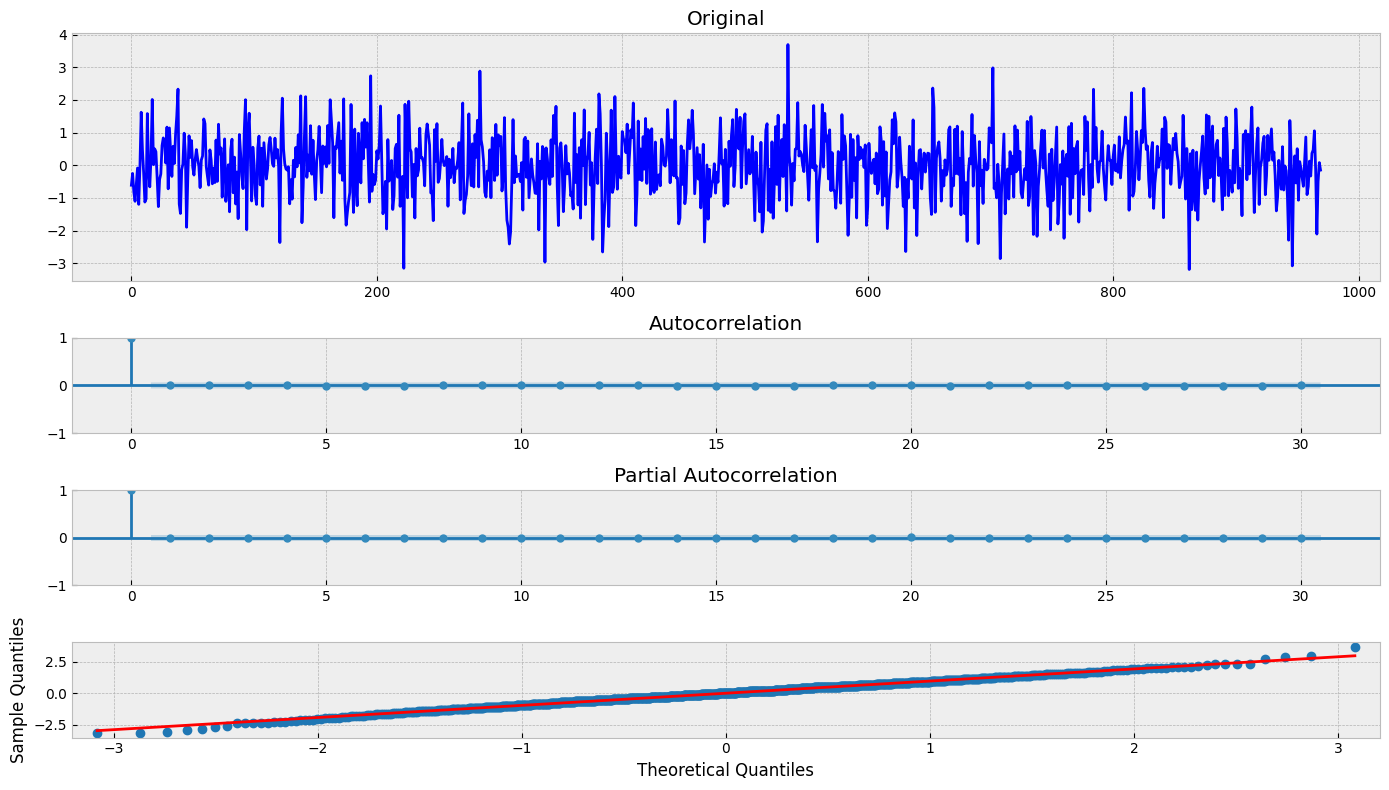

In [10]:
tsplot(md1.resid, lags=30)

## Симуляция процесса AR(2) с параметрами 0.6 и 0.3

In [19]:
np.random.seed(1)
n_samples = int(1000)
a1 = .6
a2 = .3

Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of observations used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


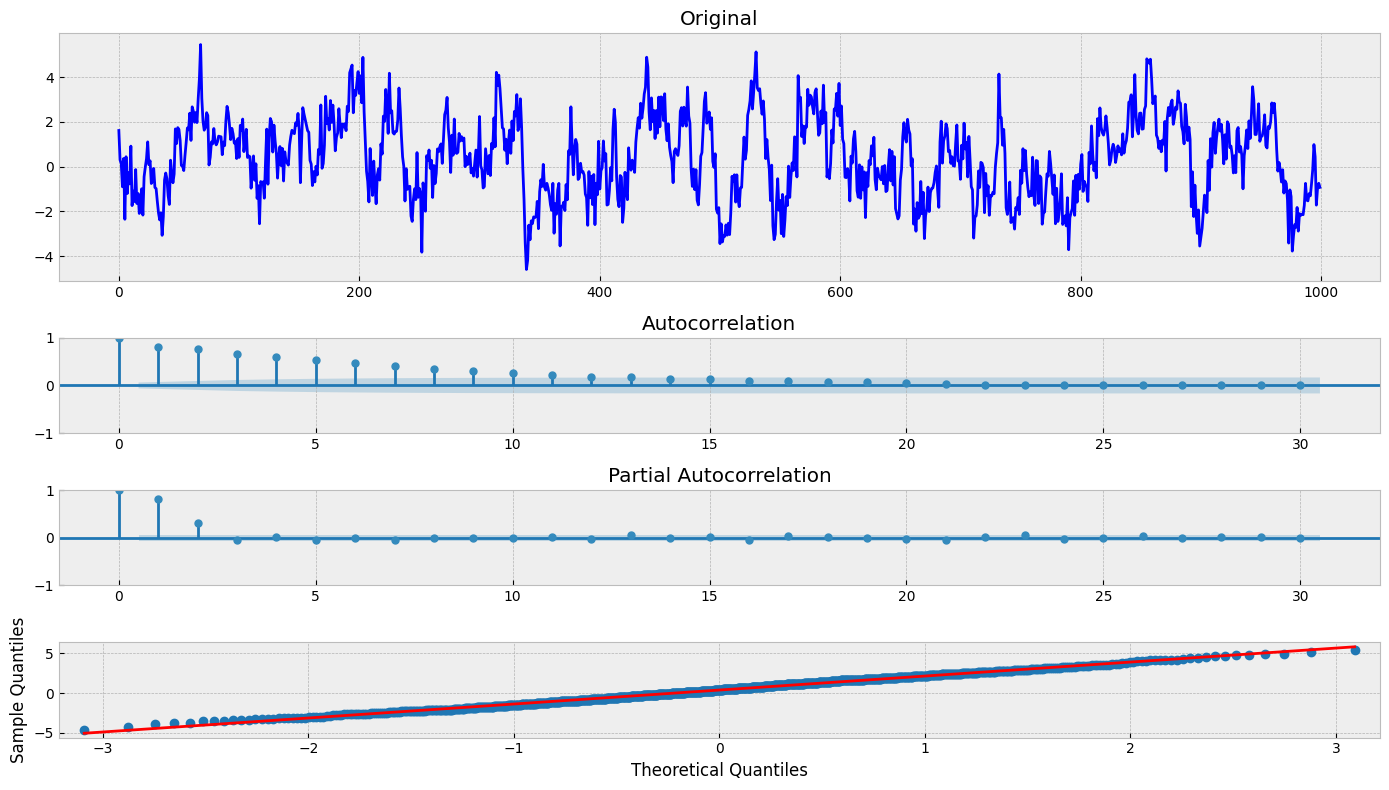

In [20]:
x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = a1 * x[t - 1] + a2 * x[t - 2] + w[t]

tsplot(x, lags=30)

In [136]:
md1 = AR(x, lags=30, trend='n').fit()
est_order = ar_select_order(x, maxlag=3)
print(f'\nalpha estimate: {md1.params[1: 3]}')
est_order.ar_lags


alpha estimate: [ 0.31448158 -0.0335453 ]


[1, 2]

Results of Dickey-Fuller Test:
Test Statistic                 -31.179434
p-value                          0.000000
#Lags Used                       0.000000
Number of observations used    969.000000
Critical Value (1%)             -3.437116
Critical Value (5%)             -2.864527
Critical Value (10%)            -2.568361
dtype: float64


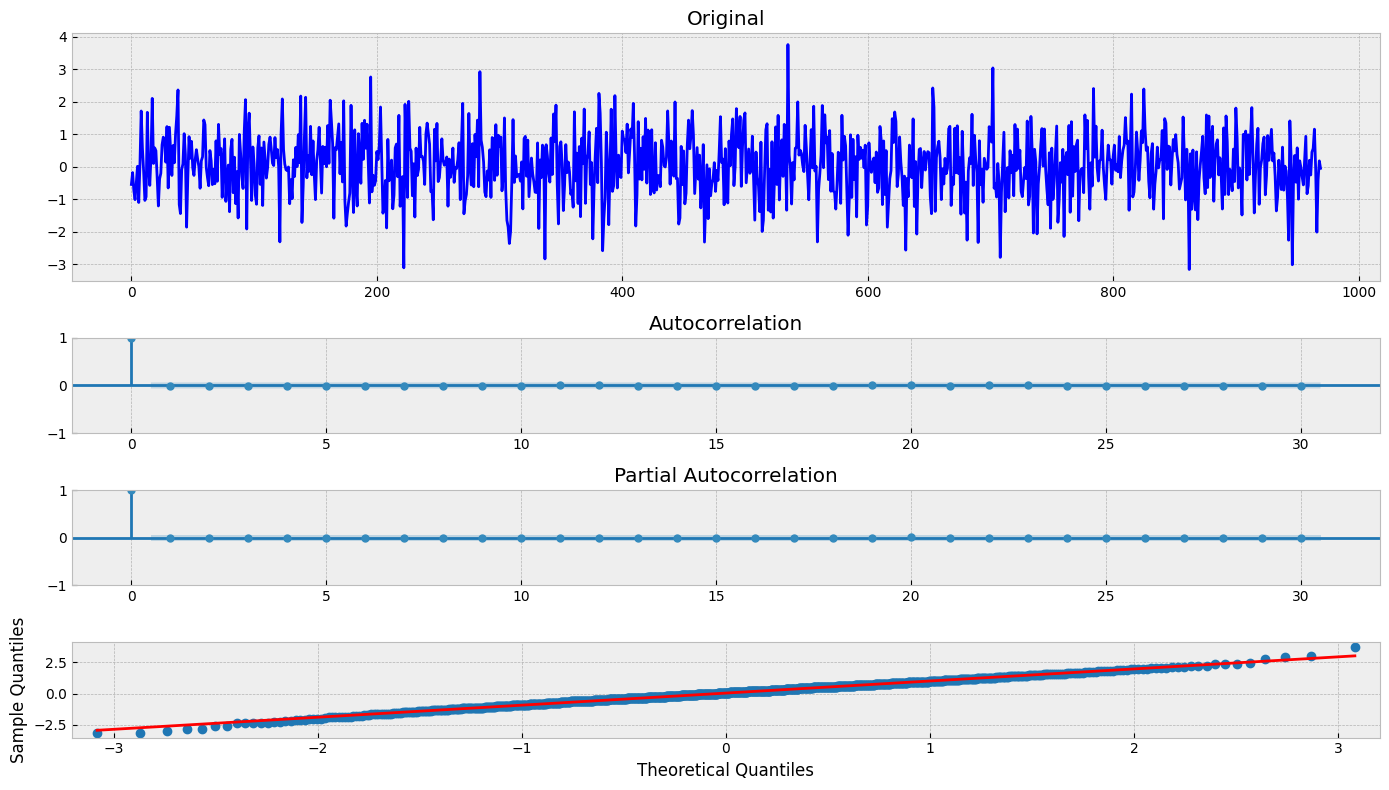

In [137]:
tsplot(md1.resid, lags=30)

In [138]:
series = pd.read_csv("data/Series/international-airline-passengers.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


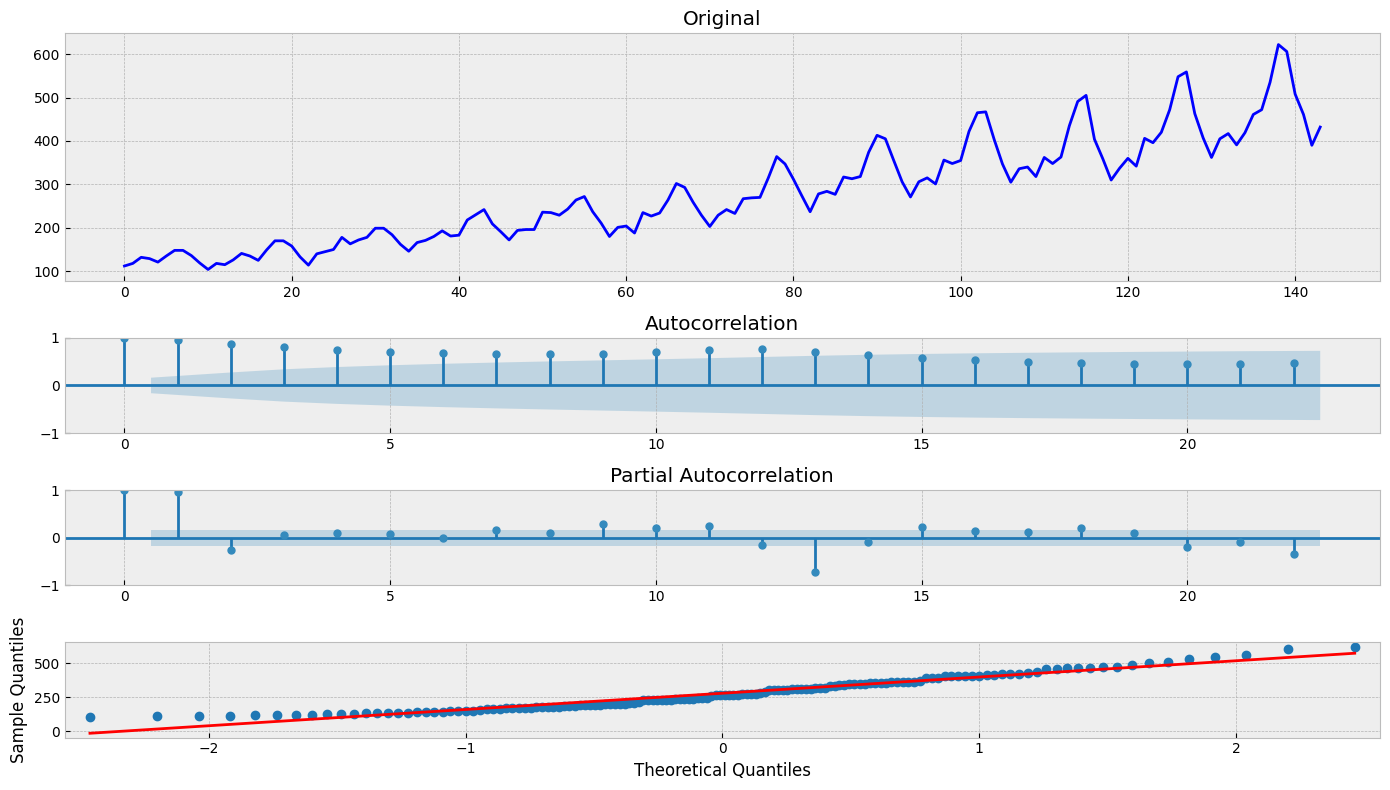

In [139]:
tsplot(series)

In [140]:
mdl = AR(series.values, lags=30, trend='c').fit()
est_order = ar_select_order(series, maxlag=30)
print(f'alpha estimate:\n{md1.params}')
est_order.ar_lags

alpha estimate:
[ 0.5889984   0.31448158 -0.0335453   0.04311727 -0.02049638  0.01443267
 -0.03541785 -0.00561968 -0.00418893 -0.01004223  0.03462041 -0.06449197
  0.04862608 -0.00401265  0.01905311 -0.05040854  0.03467016  0.01588642
  0.03304697 -0.00599115 -0.07375457 -0.02803392  0.08585626 -0.03987362
 -0.01555951  0.0265313  -0.00872783  0.00241703  0.02721222 -0.00750855]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Results of Dickey-Fuller Test:
Test Statistic                -1.048611e+01
p-value                        1.179268e-18
#Lags Used                     0.000000e+00
Number of observations used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


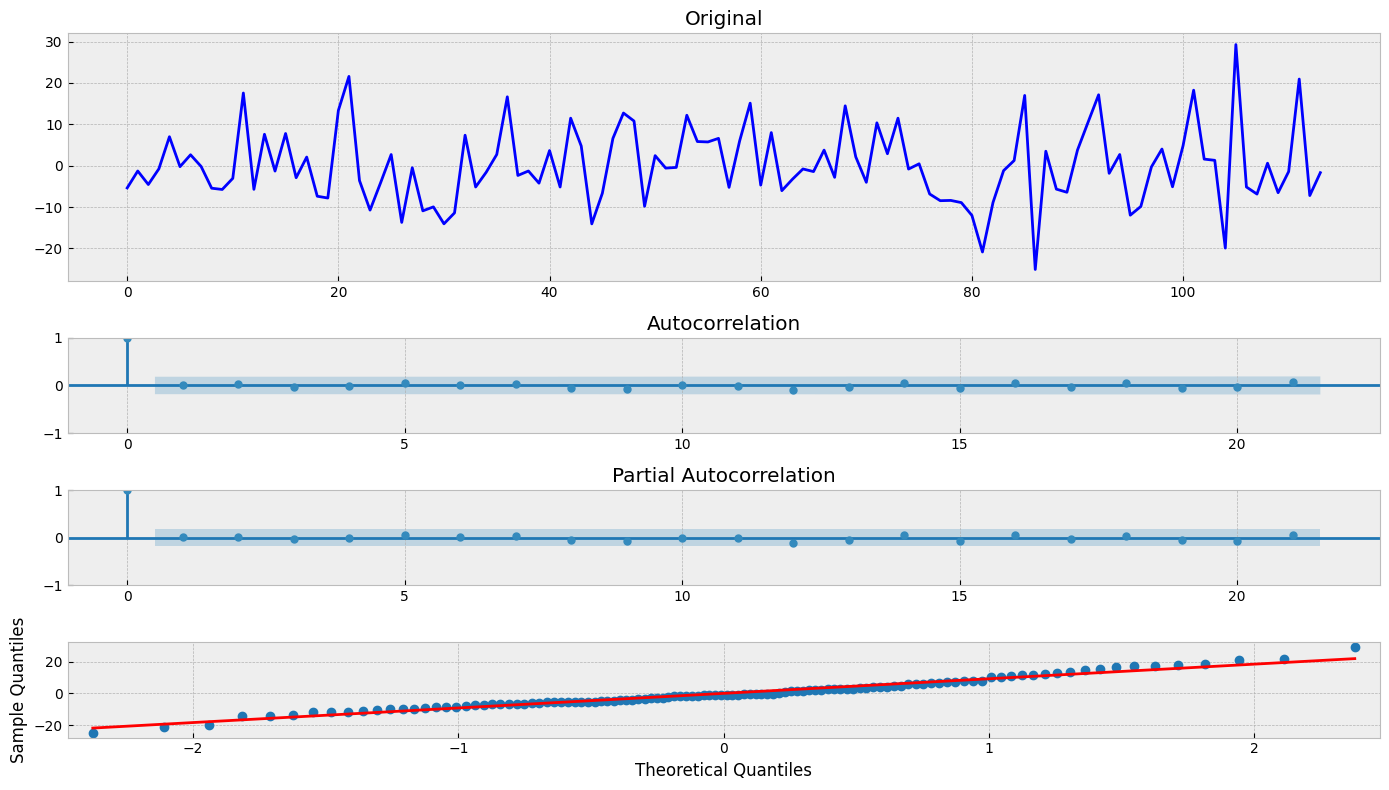

In [133]:
tsplot(mdl.resid)

Results of Dickey-Fuller Test:
Test Statistic                  -19.299024
p-value                           0.000000
#Lags Used                       13.000000
Number of observations used    4986.000000
Critical Value (1%)              -3.431662
Critical Value (5%)              -2.862120
Critical Value (10%)             -2.567079
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -9067.974
Date:                Sat, 10 Dec 2022   AIC                          18141.947
Time:                        09:50:37   BIC                          18161.498
Sample:                             0   HQIC                         18148.799
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef

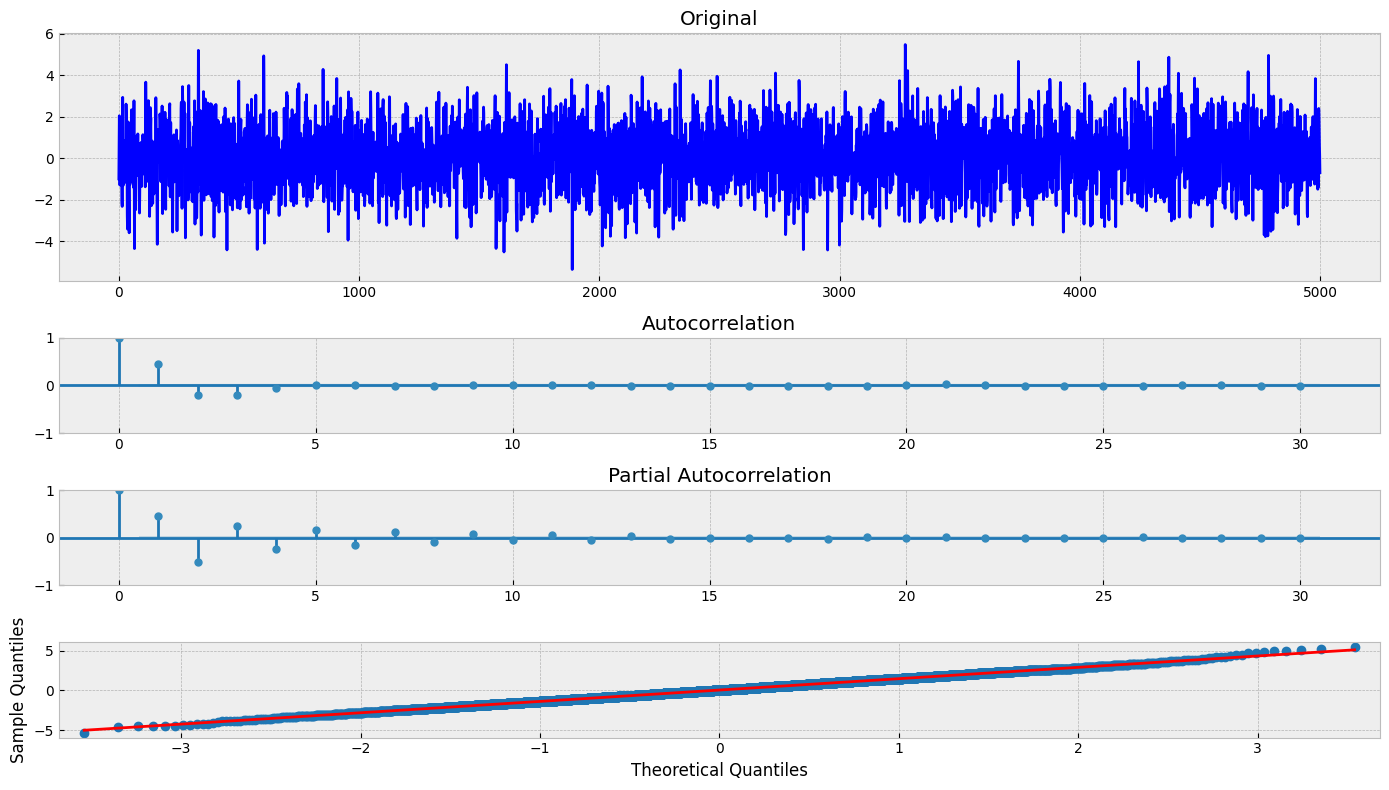

In [180]:
max_lag = 30
n = int(5000)
burn = int(n / 10)
alphas = np.array([.5, -.25])
betas = np.array([.5, -.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARIMA(arma22, order=(1, 2, 1)).fit()
print(mdl.summary())

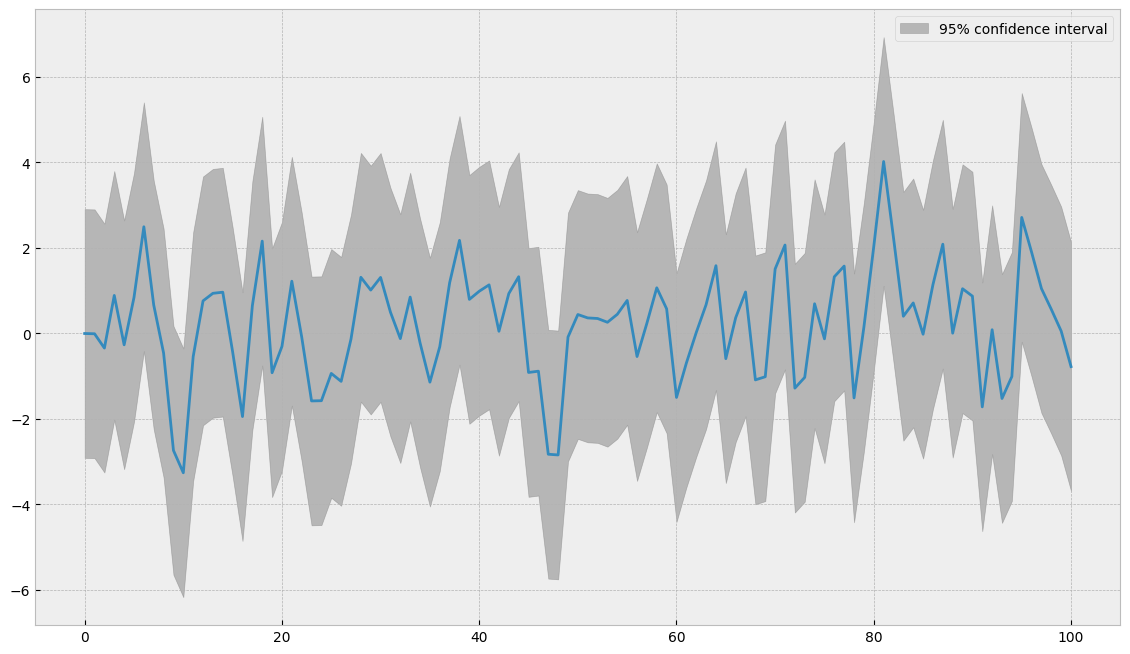

In [181]:
from statsmodels.graphics.tsaplots import plot_predict

with plt.style.context(style='bmh'):
        plt.figure(figsize=(14, 8))
        ax = plt.axes()
        plot_predict(mdl, start=4900, end=5000, ax=ax)

In [182]:
mdl.aic

18141.94714547364

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for k in range(2):
    for i in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i, k,  j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, k, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))